# 🎓 **Applied Artificial Intelligence Master**

## 🤖 **Course: Fintech and Digital Innovation in Finance (Gpo 10)**

### 🏛️ Tecnológico de Monterrey

#### 👨‍🏫 **Lead Professor:** Marie-Ève Malette
#### 👩‍🏫 **Assistant Professor:** Yetnalezi Quintas Ruiz

### 📊 **Project 4 |  Section A: Advanced RAG techniques & Sentiment Analysis on S&P 500 news**

#### 📅 **August 13th, 2025**

#### **Student:**
* 🧑‍💻 Oscar Enrique García García (A01016093)

# Introduction to reranking: an advanced RAG technique

In this notebook, you will test an advanced RAG technique: using a reranker (CrossEncoder model) to improve the retrieval of news in a RAG pipeline.

The notebook is partially filled with code. You will complete it by writing the missing code, running evaluations, and comparing results.

# 📌 Objectives

By the end of this notebook, students will be able to:

1. **Create and Use a Synthetic Evaluation Dataset:**
   - Automatically generate natural language questions corresponding to news articles using an LLM.
   - Construct a test set to assess the quality of retrieved answers.

2. **Evaluate Baseline RAG Performance Without Reranking:**
   - Measure how often the original article appears in the top-k results using FAISS alone.
   - Record retrieval accuracy and position for each query.

3. **Apply a Cross-Encoder Reranker to Improve Retrieval:**
   - Use a pretrained CrossEncoder model to rerank top FAISS results.
   - Evaluate improvements in the ranking of correct articles after reranking.

4. **Compare Retrieval Performance With and Without Reranking:**
   - Compute and visualize differences in rank positions before and after reranking.
   - Analyze statistical improvements (e.g., average rank, frequency at position 0).

5. **Reflect on the Impact of Reranking in RAG Pipelines:**
   - Discuss how reranking enhances retrieval quality in a RAG context.
   - Identify scenarios where reranking may offer the most value, and propose further improvements.


## Install and Import librairies
Run the following cell to install required libraries. These include `sentence-transformers` for embeddings and reranking, and `faiss-cpu` for vector similarity search.

In [1]:
%pip install sentence-transformers
%pip install faiss-cpu
%pip install openai

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from sentence_transformers import SentenceTransformer
import faiss
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import faiss
import os, random, re, math, json
from datetime import datetime

/Users/oscar.garcia@digitalfemsa.com/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Load S&P 500 news
We will work with a dataset of financial news headlines and summaries. You will:
 - Load the data
 - Convert the publication date column to datetime
 - Drop duplicate summaries

In [3]:
df_news = pd.read_csv('df_news.csv')
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']).dt.date
display(df_news)
print(df_news.shape)

df_news.drop_duplicates('SUMMARY', inplace=True)
print(df_news.shape)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


(4871, 6)
(3976, 6)


## Implement a Faiss Vector Store with Sentence Transfomer embeddings
This section is already implemented. It uses a sentence transformer to encode news summaries into vector embeddings and stores them in a FAISS index.
 
We also define a simple class `FaissVectorStore` that allows for efficient retrieval.


In [4]:
df_news['EMBEDDED_TEXT'] = df_news['TITLE'] + ' : ' + df_news['SUMMARY']

In [5]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [6]:
# Load model and compute embeddings
text_embeddings = model.encode(df_news['SUMMARY'].tolist(), convert_to_numpy=True)

# Normalize embeddings to use cosine similarity (via inner product in FAISS)
text_embeddings = text_embeddings / np.linalg.norm(text_embeddings, axis=1, keepdims=True)

# Prepare metadata
documents = df_news['SUMMARY'].tolist()
metadata = [
    {
        'PUBLICATION_DATE': row['PUBLICATION_DATE'], 
        'TICKER': row['TICKER'], 
        'PROVIDER': row['PROVIDER']
    }
    for _, row in df_news.iterrows()
]

In [7]:
embedding_dim = text_embeddings.shape[1]
faiss_index = faiss.IndexFlatIP(embedding_dim)  # Cosine similarity via inner product
faiss_index.add(text_embeddings)

In [8]:
class FaissVectorStore:
    def __init__(self, model, index, embeddings, documents, metadata):
        self.model = model
        self.index = index
        self.embeddings = embeddings
        self.documents = documents
        self.metadata = metadata

    def search(self, query, k=5, metadata_filter=None):
        query_embedding = self.model.encode([query])
        query_embedding = query_embedding / np.linalg.norm(query_embedding)

        if metadata_filter:
            filtered_indices = [i for i, meta in enumerate(self.metadata) if metadata_filter(meta)]
            if not filtered_indices:
                return []
            filtered_embeddings = self.embeddings[filtered_indices]
            temp_index = faiss.IndexFlatIP(filtered_embeddings.shape[1])
            temp_index.add(filtered_embeddings)
            D, I = temp_index.search(query_embedding, k)
            indices = [filtered_indices[i] for i in I[0]]
        else:
            D, I = self.index.search(query_embedding, k)
            indices = I[0]
            D = D[0]

        results = []
        for idx, sim in zip(indices, D):
            results.append((self.documents[idx], self.metadata[idx], float(sim)))


        return results

In [9]:
# Create FAISS-based store
faiss_store = FaissVectorStore(
    model=model,
    index=faiss_index,
    embeddings=text_embeddings,
    documents=documents,
    metadata=metadata
)

## Creating a dataset to evaluate the reranking

👉 **Instructions**:
- In this section, we will create an evaluation dataset for reranking by:
  - Sampling **100** distinct news articles from the full dataset.
  - Generating **one natural question** per article using GPT, where the expected answer is the original article.

✅ By the end of this section, you'll have a new DataFrame (`df_news_questions`) with:
- `NEWS`: the original summary
- `QUESTION`: the corresponding question generated using GPT

> ℹ️ The generated questions will simulate user queries in a RAG pipeline.

In [10]:
df_dedup = df_news.drop_duplicates(subset=['SUMMARY']).reset_index(drop=False).rename(columns={'index': 'DOC_ID'})
df_dedup.shape

SAMPLE_N = min(100, len(df_dedup))
df_sample = df_dedup.sample(n=SAMPLE_N, random_state=42).reset_index(drop=True)

In [11]:
df_sample.head()

,DOC_ID,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL,EMBEDDED_TEXT
0,427,ANET,"Broadcom, Arista Networks initiated: Wall Stre...","Broadcom, Arista Networks initiated: Wall Stre...",2025-05-28,The Fly,https://finance.yahoo.com/news/broadcom-arista...,"Broadcom, Arista Networks initiated: Wall Stre..."
1,1600,EMR,Investors Heavily Search Emerson Electric Co. ...,Emerson Electric (EMR) has received quite a bi...,2025-05-12,Zacks,https://finance.yahoo.com/news/investors-heavi...,Investors Heavily Search Emerson Electric Co. ...
2,728,BXP,Why Is Ventas (VTR) Down 2.1% Since Last Earni...,Ventas (VTR) reported earnings 30 days ago. Wh...,2025-05-30,Zacks,https://finance.yahoo.com/news/why-ventas-vtr-...,Why Is Ventas (VTR) Down 2.1% Since Last Earni...
3,3769,QCOM,3 things Nvidia investors should look out for ...,Nvidia's earnings call this week will be a mar...,2025-05-28,Yahoo Finance,https://finance.yahoo.com/news/3-things-nvidia...,3 things Nvidia investors should look out for ...
4,2711,KR,Inflation-weary Americans queue for toilet pap...,Inflation-scarred American consumers are putti...,2025-05-29,Financial Times,https://finance.yahoo.com/news/inflation-weary...,Inflation-weary Americans queue for toilet pap...


### Create OpenAI connector
You’ll use OpenAI’s GPT model to generate natural questions corresponding to each sampled news summary. These questions will be used to test the retrieval system.

✅ This cell contains an API key for demonstration purposes. You **must** use your own API key when running this notebook.


In [14]:
%pip install python-dotenv
from dotenv import load_dotenv
load_dotenv()

api_key = os.getenv("OPENAI_API_KEY")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [15]:
from openai import OpenAI
client = OpenAI(api_key=api_key)

response = client.responses.create(
    model="gpt-4o-mini",
    input="Write a one-sentence bedtime story about a unicorn."
)

print(response.output_text)

Under a starlit sky, a gentle unicorn named Luna spread her shimmering wings and flew to the moon, where she painted dreams for all the children sleeping on Earth.


### Using GPT to generate a question based on a news
Based on the instruction above, you need to use GPT to create a evaluation dataset. 

**Clarification** Specifically, the goal is to generate a natural question whose correct answer is the news summary. For example, if the news is about a company announcing layoffs, a good question could be: ‘Which company recently announced job cuts in its tech division?


In [16]:
prompt = """
Given the news headline provided below, 
give me a question that would justify retrieving this specific news headline in a RAG system

News headlines:
{news}

Give me a question for which the answer is the news headline:
QUESTION

**Important**
dont answer anything else other than the question!
"""

In [17]:
NEWS_FIELD = 'SUMMARY'

In [18]:
# ---- Function to generate a question from GPT ----
def generate_question_for_summary(summary: str,
                                   model: str = "gpt-4o-mini",
                                   max_retries: int = 3,
                                   sleep_base: float = 1.5,
                                   prompt: str = prompt
                                   ) -> str:
    prompt = prompt.format(news=summary)
    for attempt in range(max_retries):
        try:
            resp = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": "You generate one concise question whose correct answer is the given news summary."},
                    {"role": "user", "content": prompt},
                ],
                temperature=0.2,
                max_tokens=64,
            )
            text = resp.choices[0].message.content.strip()
            text = re.sub(r"\s+", " ", text)
            if "?" in text:
                text = text.split("?")[0].strip() + "?"
            elif not text.endswith("?"):
                text = text.strip() + "?"
            return text
        except Exception as e:
            if attempt == max_retries - 1:
                return f"What event is described by the headline: {headline}?"
            time.sleep(sleep_base * (attempt + 1))


In [19]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [20]:
questions = []
for _, row in df_sample.iterrows():
    news_text = str(row[NEWS_FIELD])
    q = generate_question_for_summary(news_text)
    questions.append(q)

df_news_questions = pd.DataFrame({
    "NEWS": df_sample["SUMMARY"].astype(str).values,
    "QUESTION": questions
})

display(df_news_questions.head(10))
print(f"Generated {len(df_news_questions)} question–news pairs using model gpt-4o-mini.")

,NEWS,QUESTION
0,"Broadcom, Arista Networks initiated: Wall Street's top analyst calls",What recent analyst calls have been made regarding Broadcom and Arista Networks?
1,"Emerson Electric (EMR) has received quite a bit of attention from Zacks.com users lately. Therefore, it is wise to be aware of the facts that can impact the stock's prospects.",What recent developments have drawn attention to Emerson Electric (EMR) among Zacks.com users?
2,Ventas (VTR) reported earnings 30 days ago. What's next for the stock? We take a look at earnings estimates for some clues.,What recent developments have occurred regarding Ventas (VTR) earnings and future stock estimates?
3,Nvidia's earnings call this week will be a market mover. Here are the top things you need to look out for.,What are the key points to watch for in Nvidia's upcoming earnings call that could impact the market?
4,"Inflation-scarred American consumers are putting up with long lines and paying cash for the privilege of shopping at members-only stores, which...",What are American consumers doing in response to inflation when shopping at members-only stores?
5,"Delivery service DoorDash (DASH) reported its largest quarterly profit to date at $193 million for Q1 2025 — a remarkable swing from a $23 million loss this time last year. Yet, shares have tumbled over 10% as the company also announced two major acquisitions totaling $5 billion, leaving investors wondering whether the food delivery giant is growing too fast for its own good. The answer isn’t immediately clear. Therefore, investors might want to hold off on this one for now and let the dust sett",What were the financial results and investor reactions for DoorDash in Q1 2025?
6,"Strong capital efficiency and commercial growth make ELV appealing, but regulatory and cost headwinds keep investors cautious.",What factors are influencing investor sentiment towards ELV despite its strong capital efficiency and commercial growth?
7,"Argus recently lowered the price target on Equinix, Inc. (NASDAQ:EQIX) to $955 from $972 but kept a Buy rating on the shares. Equinix, Inc. (EQIX) is a California-based real estate trust that operates data centers and other technology assets. In an investor note, the analyst highlighted that the stock had been volatile, reflecting Information Technology […]","What recent change did Argus make to the price target for Equinix, Inc. while maintaining its Buy rating?"
8,"The Zacks Internet software industry participants like ANET, MNDY and PCTY are benefiting from high demand for SaaS due to the increasing need for hybrid work, learning and diagnosis software, as well as cybersecurity applications.",Which companies in the Zacks Internet software industry are benefiting from the high demand for SaaS related to hybrid work and cybersecurity applications?
9,This marks the ninth time in 37 years this unstoppable company has completed a forward split.,How many times has this company completed a forward split in the last 37 years?


Generated 100 question–news pairs using model gpt-4o-mini.


## Evaluating RAG without and with reranking

You will now compare a basic RAG pipeline using FAISS with an enhanced version that includes reranking.


### RAG without reranking

👉 **Instructions**:
1. Implement a function that retrieves the **top 5** news summaries for a given question using your FAISS vector store.
2. For each `(QUESTION, NEWS)` pair:
   - Search using the `QUESTION`
   - Check if the corresponding `NEWS` appears in the top 5 retrieved summaries.
   - Record the **rank position** (from 0 to 4) in a new column `NO_RERANKER`.
   - If the news is **not found**, store `'not found'`.

✅ This step helps measure the baseline performance of your vector-based retrieval without reranking.

> 💡 Tip: You can store the retrieved results in a dictionary or list to avoid recomputation.

In [21]:
TOP_K = 5

In [22]:
def retrieve_topk(question: str, k: int = TOP_K):
    """Returns list of (doc_text, meta, score) from the FAISS store."""
    return faiss_store.search(question, k=k)

# Cache to avoid calling FAISS repeatedly if you rerun cells
retrieval_cache = {}

def rank_of_gold_exact(news_summary: str, results):
    """
    Find the rank (0..k-1) of the gold NEWS in FAISS results via exact string equality.
    Handles duplicates by accepting the first exact match.
    """
    gold = str(news_summary)
    for idx, (doc_text, meta, score) in enumerate(results):
        if gold == str(doc_text):
            return idx
    return None  # not found in top-k


In [23]:
# Compute ranks for no-reranker
no_reranker_ranks = []
for _, row in df_news_questions.iterrows():
    q = str(row["QUESTION"])
    if q not in retrieval_cache:
        retrieval_cache[q] = retrieve_topk(q, k=TOP_K)
    results = retrieval_cache[q]
    r = rank_of_gold_exact(row["NEWS"], results)
    no_reranker_ranks.append(r if r is not None else "not found")

df_news_questions = df_news_questions.copy()
df_news_questions["NO_RERANKER"] = no_reranker_ranks

# Quick metrics
found_mask = df_news_questions["NO_RERANKER"] != "not found"
found_positions = [r for r in df_news_questions["NO_RERANKER"] if r != "not found"]

hit_at_1 = float(np.mean([r == 0 for r in found_positions])) if found_positions else 0.0
found_rate = float(np.mean(found_mask))
avg_rank_found = float(np.mean(found_positions)) if found_positions else float("nan")

print(f"Baseline (no reranker) over {len(df_news_questions)} queries")
print(f"- Found rate (Hit@5): {found_rate:.2%}")
print(f"- Hit@1 (among found): {hit_at_1:.2%}")
print(f"- Avg rank (among found): {avg_rank_found:.2f}")

display(df_news_questions.head(10)[["QUESTION","NEWS","NO_RERANKER"]])

Baseline (no reranker) over 100 queries
- Found rate (Hit@5): 96.00%
- Hit@1 (among found): 91.67%
- Avg rank (among found): 0.14


,QUESTION,NEWS,NO_RERANKER
0,What recent analyst calls have been made regarding Broadcom and Arista Networks?,"Broadcom, Arista Networks initiated: Wall Street's top analyst calls",0
1,What recent developments have drawn attention to Emerson Electric (EMR) among Zacks.com users?,"Emerson Electric (EMR) has received quite a bit of attention from Zacks.com users lately. Therefore, it is wise to be aware of the facts that can impact the stock's prospects.",0
2,What recent developments have occurred regarding Ventas (VTR) earnings and future stock estimates?,Ventas (VTR) reported earnings 30 days ago. What's next for the stock? We take a look at earnings estimates for some clues.,0
3,What are the key points to watch for in Nvidia's upcoming earnings call that could impact the market?,Nvidia's earnings call this week will be a market mover. Here are the top things you need to look out for.,0
4,What are American consumers doing in response to inflation when shopping at members-only stores?,"Inflation-scarred American consumers are putting up with long lines and paying cash for the privilege of shopping at members-only stores, which...",0
5,What were the financial results and investor reactions for DoorDash in Q1 2025?,"Delivery service DoorDash (DASH) reported its largest quarterly profit to date at $193 million for Q1 2025 — a remarkable swing from a $23 million loss this time last year. Yet, shares have tumbled over 10% as the company also announced two major acquisitions totaling $5 billion, leaving investors wondering whether the food delivery giant is growing too fast for its own good. The answer isn’t immediately clear. Therefore, investors might want to hold off on this one for now and let the dust sett",2
6,What factors are influencing investor sentiment towards ELV despite its strong capital efficiency and commercial growth?,"Strong capital efficiency and commercial growth make ELV appealing, but regulatory and cost headwinds keep investors cautious.",0
7,"What recent change did Argus make to the price target for Equinix, Inc. while maintaining its Buy rating?","Argus recently lowered the price target on Equinix, Inc. (NASDAQ:EQIX) to $955 from $972 but kept a Buy rating on the shares. Equinix, Inc. (EQIX) is a California-based real estate trust that operates data centers and other technology assets. In an investor note, the analyst highlighted that the stock had been volatile, reflecting Information Technology […]",0
8,Which companies in the Zacks Internet software industry are benefiting from the high demand for SaaS related to hybrid work and cybersecurity applications?,"The Zacks Internet software industry participants like ANET, MNDY and PCTY are benefiting from high demand for SaaS due to the increasing need for hybrid work, learning and diagnosis software, as well as cybersecurity applications.",0
9,How many times has this company completed a forward split in the last 37 years?,This marks the ninth time in 37 years this unstoppable company has completed a forward split.,0


### RAG with reranking
In this section, you will add reranking using a cross-encoder model (`ms-marco-MiniLM-L12-v2`) to improve retrieval.

👉 **Instructions**:
1. Retrieve the **top 100** summaries from FAISS for each question.
2. Rerank these summaries using the CrossEncoder model: `cross-encoder/ms-marco-MiniLM-L12-v2`.
For each question, retrieve the top-100 summaries from FAISS, then rerank only those 100 using the CrossEncoder model.
3. Return the **top 5** reranked results.
4. For each `(QUESTION, NEWS)` pair, record the new rank (0–4) of the correct news in a new column: `WITH_RERANKER`.
5. Again, if the news is not found, store `'not found'`.

✅ This step lets you evaluate how much the reranker improves the relevance of retrieved results.

> ℹ️ The CrossEncoder scores each (question, summary) pair individually, so this step may take longer to run.



In [24]:
from sentence_transformers import CrossEncoder

model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L12-v2')
scores = model.predict([
    ("How many people live in Berlin?", "Berlin had a population of 3,520,031 registered inhabitants in an area of 891.82 square kilometers."),
    ("How many people live in Berlin?", "Berlin is well known for its museums."),
])
print(scores)

config.json:   0%|          | 0.00/791 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

[ 9.218913  -4.0780306]


In [25]:
TOP_K_BASE = 100
TOP_K_FINAL = 5

In [26]:
retrieval_cache = {}
retrieval_cache_100 = {}

In [27]:
def retrieve_topk_faiss(q: str, k: int = TOP_K_BASE):
    """Return list of (doc_text, meta, score) from FAISS."""
    return faiss_store.search(q, k=k)

def rerank_with_crossencoder(question: str, candidates, model):
    """
    candidates: list of (doc_text, meta, score_from_faiss)
    returns: list of (doc_text, meta, ce_score) sorted by ce_score desc
    """
    if not candidates:
        return []
    pairs = [(question, doc) for (doc, meta, score) in candidates]
    ce_scores = model.predict(pairs).tolist()
    rescored = [(doc, meta, float(s)) for (s, (doc, meta, _)) in zip(ce_scores, candidates)]
    rescored.sort(key=lambda x: x[2], reverse=True)
    return rescored

def rank_of_gold_exact(news_summary: str, reranked_topk):
    """Find 0..TOP_K_FINAL-1 of gold NEWS among reranked_topk via exact string match on doc_text."""
    gold = str(news_summary)
    for idx, (doc_text, meta, ce_score) in enumerate(reranked_topk):
        if gold == str(doc_text):
            return idx
    return None

In [28]:
with_reranker_ranks = []
for _, row in df_news_questions.iterrows():
    q = str(row["QUESTION"])
    # Fetch or compute FAISS top-100
    if q not in retrieval_cache_100:
        retrieval_cache_100[q] = retrieve_topk_faiss(q, k=TOP_K_BASE)
    top100 = retrieval_cache_100[q]
    # Rerank those 100
    reranked = rerank_with_crossencoder(q, top100, model)
    # Take top-5 for evaluation
    top5 = reranked[:TOP_K_FINAL]
    r = rank_of_gold_exact(row["NEWS"], top5)
    with_reranker_ranks.append(r if r is not None else "not found")

df_news_questions = df_news_questions.copy()
df_news_questions["WITH_RERANKER"] = with_reranker_ranks

# 3) Quick metrics
def _extract_found_positions(series):
    return [r for r in series if r != "not found"]

found_mask = df_news_questions["WITH_RERANKER"] != "not found"
found_positions = _extract_found_positions(df_news_questions["WITH_RERANKER"])

hit_at_1_ce = float(np.mean([r == 0 for r in found_positions])) if found_positions else 0.0
found_rate_ce = float(np.mean(found_mask))
avg_rank_found_ce = float(np.mean(found_positions)) if found_positions else float("nan")

print(f"Reranker results over {len(df_news_questions)} queries")
print(f"- Found rate (Hit@5): {found_rate_ce:.2%}")
print(f"- Hit@1 (among found): {hit_at_1_ce:.2%}")
print(f"- Avg rank (among found): {avg_rank_found_ce:.2f}")

# 4) If baseline exists, print simple deltas
if "NO_RERANKER" in df_news_questions.columns:
    base_found = df_news_questions["NO_RERANKER"] != "not found"
    base_found_positions = _extract_found_positions(df_news_questions["NO_RERANKER"])
    hit_at_1_base = float(np.mean([r == 0 for r in base_found_positions])) if base_found_positions else 0.0
    found_rate_base = float(np.mean(base_found))
    avg_rank_found_base = float(np.mean(base_found_positions)) if base_found_positions else float("nan")

    print("\nΔ vs No-Reranker:")
    print(f"- Found rate Δ: {(found_rate_ce - found_rate_base):+.2%} (CE {found_rate_ce:.2%} vs Base {found_rate_base:.2%})")
    print(f"- Hit@1 Δ: {(hit_at_1_ce - hit_at_1_base):+.2%} (CE {hit_at_1_ce:.2%} vs Base {hit_at_1_base:.2%})")
    if not (np.isnan(avg_rank_found_ce) or np.isnan(avg_rank_found_base)):
        print(f"- Avg rank (found) Δ: {(avg_rank_found_ce - avg_rank_found_base):+.2f} (lower is better)")

display(df_news_questions[["QUESTION", "NEWS", "NO_RERANKER","WITH_RERANKER"]].head(10))



Reranker results over 100 queries
- Found rate (Hit@5): 99.00%
- Hit@1 (among found): 93.94%
- Avg rank (among found): 0.09

Δ vs No-Reranker:
- Found rate Δ: +3.00% (CE 99.00% vs Base 96.00%)
- Hit@1 Δ: +2.27% (CE 93.94% vs Base 91.67%)
- Avg rank (found) Δ: -0.04 (lower is better)


,QUESTION,NEWS,NO_RERANKER,WITH_RERANKER
0,What recent analyst calls have been made regarding Broadcom and Arista Networks?,"Broadcom, Arista Networks initiated: Wall Street's top analyst calls",0,0
1,What recent developments have drawn attention to Emerson Electric (EMR) among Zacks.com users?,"Emerson Electric (EMR) has received quite a bit of attention from Zacks.com users lately. Therefore, it is wise to be aware of the facts that can impact the stock's prospects.",0,0
2,What recent developments have occurred regarding Ventas (VTR) earnings and future stock estimates?,Ventas (VTR) reported earnings 30 days ago. What's next for the stock? We take a look at earnings estimates for some clues.,0,0
3,What are the key points to watch for in Nvidia's upcoming earnings call that could impact the market?,Nvidia's earnings call this week will be a market mover. Here are the top things you need to look out for.,0,0
4,What are American consumers doing in response to inflation when shopping at members-only stores?,"Inflation-scarred American consumers are putting up with long lines and paying cash for the privilege of shopping at members-only stores, which...",0,0
5,What were the financial results and investor reactions for DoorDash in Q1 2025?,"Delivery service DoorDash (DASH) reported its largest quarterly profit to date at $193 million for Q1 2025 — a remarkable swing from a $23 million loss this time last year. Yet, shares have tumbled over 10% as the company also announced two major acquisitions totaling $5 billion, leaving investors wondering whether the food delivery giant is growing too fast for its own good. The answer isn’t immediately clear. Therefore, investors might want to hold off on this one for now and let the dust sett",2,0
6,What factors are influencing investor sentiment towards ELV despite its strong capital efficiency and commercial growth?,"Strong capital efficiency and commercial growth make ELV appealing, but regulatory and cost headwinds keep investors cautious.",0,0
7,"What recent change did Argus make to the price target for Equinix, Inc. while maintaining its Buy rating?","Argus recently lowered the price target on Equinix, Inc. (NASDAQ:EQIX) to $955 from $972 but kept a Buy rating on the shares. Equinix, Inc. (EQIX) is a California-based real estate trust that operates data centers and other technology assets. In an investor note, the analyst highlighted that the stock had been volatile, reflecting Information Technology […]",0,0
8,Which companies in the Zacks Internet software industry are benefiting from the high demand for SaaS related to hybrid work and cybersecurity applications?,"The Zacks Internet software industry participants like ANET, MNDY and PCTY are benefiting from high demand for SaaS due to the increasing need for hybrid work, learning and diagnosis software, as well as cybersecurity applications.",0,0
9,How many times has this company completed a forward split in the last 37 years?,This marks the ninth time in 37 years this unstoppable company has completed a forward split.,0,0


## Comparison and analysis

👉 **Instructions**:
- Analyze the impact of reranking using your results.
- Write short answers to the following:
  1. Did reranking improve the **average position** of the correct news?
  2. How often was the correct article at **position 0** with and without reranking?
- You may use:
  - Value counts (`.value_counts()`)
  - Descriptive statistics (`.mean()`, `.median()`)
  - Simple plots (e.g. bar charts or histograms)

✅ This is your opportunity to reflect on the performance of the reranker and think critically about retrieval quality.

> ✨ Optional: You can create a summary table comparing the overall accuracy and coverage between the two methods.

,Metric,No Reranker,Reranker,Delta (Reranker - Base)
0,Found Rate (Hit@5),0.960000,0.990000,0.030000
1,Hit@1 (overall),0.880000,0.930000,0.050000
2,Avg Rank (found),0.135417,0.090909,-0.044508
3,MRR,0.950521,0.965488,0.014967


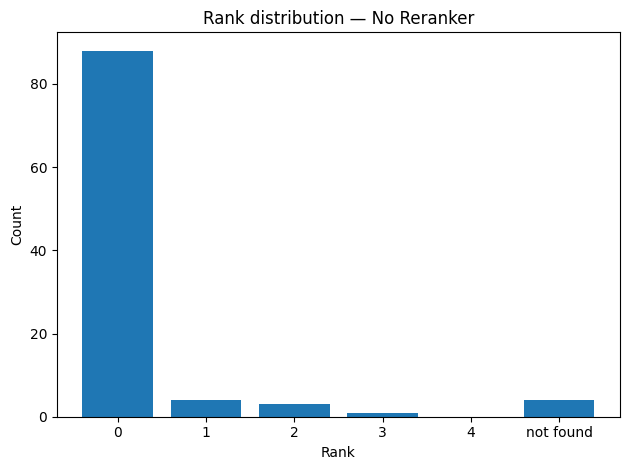

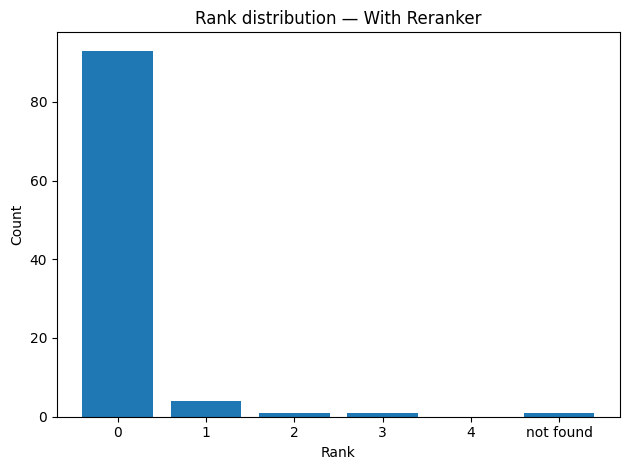

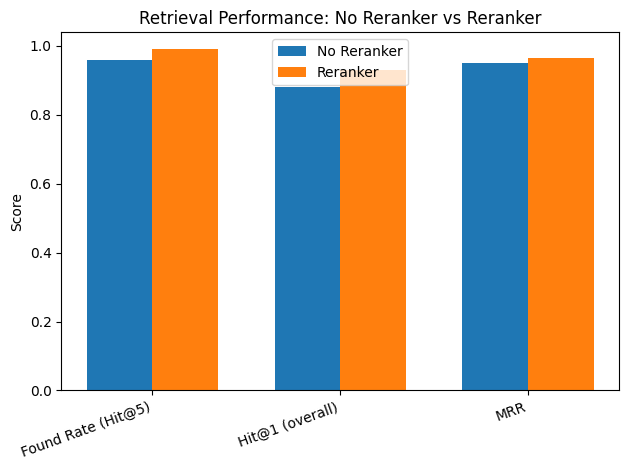

In [29]:
import matplotlib.pyplot as plt

cols = ["NO_RERANKER", "WITH_RERANKER"]

def to_numeric_ranks(series):
    return pd.to_numeric(series, errors="coerce")

def found_rate(ranks):
    """Share of queries where the correct article appears in the retrieved top-k."""
    s = to_numeric_ranks(ranks)
    return float(1.0- s.isna().mean())

def avg_rank_found(ranks):
    """Average rank among found cases only (lower is better)."""
    s = to_numeric_ranks(ranks).dropna()
    return float(s.mean()) if len(s) else float("nan")

def hit_at_1_overall(ranks):
    """Fraction of queries where the correct article is at position 0 (counts not-found as False)."""
    s = to_numeric_ranks(ranks)
    return float((s == 0).mean())

def mrr(ranks):
    """Mean Reciprocal Rank over found items (top-k)."""
    s = to_numeric_ranks(ranks)
    rr = 1.0 / (s.dropna() + 1.0)
    return float(rr.mean()) if len(rr) else 0.0

def rank_counts(series, k=5):
    """Counts for 0..k-1 and 'not found'."""
    s = to_numeric_ranks(series)
    counts = {i: int((s == i).sum()) for i in range(k)}
    counts["not found"] = int(s.isna().sum())
    return counts

# Metrics for both methods
no_r = df_news_questions["NO_RERANKER"]
ce_r = df_news_questions["WITH_RERANKER"]

metrics = {
    "Found Rate (Hit@5)": (found_rate(no_r), found_rate(ce_r)),
    "Hit@1 (overall)":    (hit_at_1_overall(no_r), hit_at_1_overall(ce_r)),
    "Avg Rank (found)":   (avg_rank_found(no_r), avg_rank_found(ce_r)),
    "MRR":                (mrr(no_r), mrr(ce_r)),
}

metrics_df = pd.DataFrame(
    [{"Metric": k, "No Reranker": v[0], "Reranker": v[1], "Delta (Reranker - Base)": v[1] - v[0]} for k, v in metrics.items()]
)

display(metrics_df)

def plot_rank_distribution(series, title, k=5):
    counts = rank_counts(series, k=k)
    labels = [str(i) for i in range(k)] + ["not found"]
    values = [counts[i] if isinstance(i, int) else counts[i] for i in list(range(k))] + [counts["not found"]]
    plt.figure()
    plt.bar(labels, values)
    plt.title(title)
    plt.xlabel("Rank")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

plot_rank_distribution(no_r, "Rank distribution — No Reranker", k=5)
plot_rank_distribution(ce_r, "Rank distribution — With Reranker", k=5)

key_metrics = ["Found Rate (Hit@5)", "Hit@1 (overall)", "MRR"]
x = np.arange(len(key_metrics))
base_vals = [metrics[m][0] for m in key_metrics]
ce_vals   = [metrics[m][1] for m in key_metrics]

plt.figure()
width = 0.35
plt.bar(x - width/2, base_vals, width, label="No Reranker")
plt.bar(x + width/2, ce_vals,   width, label="Reranker")
plt.xticks(x, key_metrics, rotation=20, ha="right")
plt.ylabel("Score")
plt.title("Retrieval Performance: No Reranker vs Reranker")
plt.legend()
plt.tight_layout()
plt.show()


### **Question 1.** Did reranking improve the **average position** of the correct news?
 

Yes, as we can see in the summary table and in the graphs, the average position pass from 0.14 (without reranking) to 0.09 (with reranking). We can conclude that the reranker obtained the "correct" document at position 0 more frequently.

### **Question 2.** How often was the correct article at **position 0** with and without reranking?


Also, as we can see in the quick metrics, the summary table and the plots, the article is found at position  88% of the times without reranking (91% without counting the not founds) while 93% of the times with reranking. With this we can enforce the hypothesis that the reranking improves the performance of the RAG model. Also, we can see that with reranking, the articles were found between the top 5 99% of the times.